In [308]:
import os
import matplotlib.pyplot as plt
import numpy as np

import TimeTag
import Visibility_OTPS as visnew
from tqdm import tqdm
from scipy.signal import find_peaks
from scipy.fft import fft, ifft
from scipy.optimize import curve_fit





### Data loading

In [314]:
ch_det = 2 # Channel for single photon detector
ch_AWG = 0 # Channel for AWG trigger
ch_piezo = 3 # Channel for piezo trigger

t_integration = 5 # Integration time for measurement

In [315]:
filename, timetag = TimeTag.save_timetags(ch_det, ch_AWG, ch_piezo,t_integration)
print(timetag)

c:\Users\LocalAdmin\Imperial College London\UQOG Quantum Memories - PH - General\Python\ORCA Experiments\Time Bin Qubit\OTPS
c:\Users\LocalAdmin\Imperial College London\UQOG Quantum Memories - PH - General\Data\2024-03\2024-03-15_TimeBinQubit\2024-03-15_143253
143253


In [310]:
# 3.8 photons per AWG, early amp oscillation, NKT laser

# folder = 'c:\\Users\\LocalAdmin\\Imperial College London\\UQOG Quantum Memories - PH - General\\Data\\2024-03\\2024-03-14_TimeBinQubit\\'
# filename = folder + os.sep + '2024-03-14_114008.ttbin'
# timetag = 114008

In [316]:
# 3.1 photons per AWG, santec on 1550 nm

folder = 'c:\\Users\\LocalAdmin\\Imperial College London\\UQOG Quantum Memories - PH - General\\Data\\2024-03\\2024-03-15_TimeBinQubit\\'
filename = folder + os.sep + '2024-03-15_143253.ttbin'
timetag = 143253

In [290]:
# 5.1 photons per AWG, no oscillation

# folder = 'c:\\Users\\LocalAdmin\\Imperial College London\\UQOG Quantum Memories - PH - General\\Data\\2024-03\\2024-03-14_TimeBinQubit\\'
# filename = folder + os.sep + '2024-03-14_100747.ttbin'
# timetag = 100747

In [291]:
# 2.3 photons per AWG

# folder = 'c:\\Users\\LocalAdmin\\Imperial College London\\UQOG Quantum Memories - PH - General\\Data\\2024-03\\2024-03-14_TimeBinQubit\\'
# filename = folder + os.sep + '2024-03-14_100620.ttbin'
# timetag = 100620

In [292]:
# 4.3 photons per AWG

# folder = 'c:\\Users\\LocalAdmin\\Imperial College London\\UQOG Quantum Memories - PH - General\\Data\\2024-03\\2024-03-13_TimeBinQubit\\'
# filename = folder + os.sep + '2024-03-13_164952.ttbin'
# timetag = 164952

In [293]:
# 2.3 photons per AWG

# folder = 'c:\\Users\\LocalAdmin\\Imperial College London\\UQOG Quantum Memories - PH - General\\Data\\2024-03\\2024-03-11_TimeBinQubit\\'
# filename = folder + os.sep + '2024-03-11_105335.ttbin'
# timetag = 105335


In [318]:
channels, timestamps = TimeTag.load_tt_data(filename)

In [319]:
print(channels)
print(timestamps)

[2. 2. 2. ... 0. 2. 2.]
[1.24469616e+12 1.24469675e+12 1.24469681e+12 ... 6.18857235e+12
 6.18857250e+12 6.18857330e+12]


### Data analysis


In [320]:
# Get overviews of the data and set parameters for the analysis

times_piezo = timestamps[np.where(channels==ch_piezo)[0]] # timestamps of piezo triggers
times_AWG = timestamps[np.where(channels==ch_AWG)[0]] # timestamps of AWG triggers
average_piezo_duration = np.mean(np.diff(times_piezo)) # average time between piezo triggers
average_AWG_duration = np.mean(np.diff(times_AWG)) # average time between AWG triggers
total_num_piezos = len(times_piezo)
total_num_AWGs = len(times_AWG)

print('Average piezo duration in seconds: ', average_piezo_duration/1e12)
print('Total number of piezos: ', total_num_piezos)
print('Average AWG duration in seconds: ', average_AWG_duration/1e12)
print('Total number of AWGs: ', total_num_AWGs)


AWG_rate = 1/(average_AWG_duration*1e-12)
print('AWG rep rate = ', AWG_rate)

laser_rep = AWG_rate*160
pulse_separation = 1/laser_rep * 4 * 10**9
print('Pulse separation = ', pulse_separation)


Average piezo duration in seconds:  0.010000642313186236
Total number of piezos:  495
Average AWG duration in seconds:  1.9966853222216433e-06
Total number of AWGs:  2476042
AWG rep rate =  500830.0451106308
Pulse separation =  49.917133055541086


In [321]:
# Define binning parameters

binwidth = 100 # histogram bin width in ps
n_bins = int(2000000/binwidth)

# How many unit bins of duration 25*average_AWG_duration are there between two piezo triggers?

num_AWG_per_piezo = len(times_AWG[np.where((times_AWG<=times_piezo[1]) & (times_AWG>=times_piezo[0]))])
print('Number of AWG triggers per piezo trigger = ', num_AWG_per_piezo)
print('Number of unit bins per piezo trigger = ', int(num_AWG_per_piezo/25))


Number of AWG triggers per piezo trigger =  5009
Number of unit bins per piezo trigger =  200


### Sequencing and chunking of data

In [322]:
# Chunk the data into piezo triggers with timestamps and channels

timestamps_piezo_list = []
channels_piezo_list = []

for i in tqdm(range(len(times_piezo)-1)):
    timestamps_piezo_list.append(timestamps[np.where((timestamps<times_piezo[i+1]) & (timestamps>times_piezo[i]))])
    channels_piezo_list.append(channels[np.where((timestamps<times_piezo[i+1]) & (timestamps>times_piezo[i]))])

# print(len(timestamps_piezo_list))
# print(timestamps_piezo_list[0])
# print(len(channels_piezo_list))
# print(channels_piezo_list[0])


100%|██████████| 494/494 [00:35<00:00, 13.78it/s]


### Save data

In [299]:
# # Save timestamps_piezo_list and channels_piezo_list to file
# d = os.getcwd()

# # Define the file path
# file_path = folder + os.sep + '2024-03-11_105335_piezo_data.npz'

# # Save the data to the file
# np.savez(file_path, timestamps_piezo_list=timestamps_piezo_list, channels_piezo_list=channels_piezo_list)


In [300]:
# # Load the data from the file
# data = np.load(file_path)

# # Extract the timestamps_piezo_list and channels_piezo_list
# timestamps_piezo_list = data['timestamps_piezo_list']
# channels_piezo_list = data['channels_piezo_list']


### Mean detection counts per AWG trigger

In [323]:
mean_det_list = []

for i in tqdm(range(len(timestamps_piezo_list))):
    total_det = 0
    time_bin_piezo_list = visnew.detection_binning(channels_piezo_list[i], timestamps_piezo_list[i], ch_AWG)

    for time in time_bin_piezo_list:
        total_det += len(time)
        mean_det = total_det/len(time_bin_piezo_list*25)
    mean_det_list.append(mean_det)

print("Mean detection rate = ", np.mean(mean_det_list))


100%|██████████| 494/494 [00:08<00:00, 60.03it/s]

Mean detection rate =  3.1324538461538465


### Functions for interference mmt

In [302]:
def get_total_count_piezo(time_bin_list, n_bins, start_bin, end_bin, integration_time, plot=True):
    """
    Function to get total detection events in time_bin_list.
    
    Parameters:
    time_bin_list: list of lists
        List of time bins with detections
    n_bins: int
        Number of bins in the histogram
    start_bin: int
        Start bin of integration time
    end_bin: int
        End bin of integration time
    integration_time: int
        Integration time in ps
    plot: bool
        If True, plot the histogram
    
    
    Returns:
    count_total: array
        Array of counts in the histogram

    
    
        """
    # How many bins of 50us duration are in integration time?
    bin_difference_integration_time = int(integration_time/(50*10**6))  

    if start_bin > end_bin:
        raise ValueError('Start bin must be smaller than end bin')
    
    if end_bin-start_bin != bin_difference_integration_time:
        raise ValueError('Integration time must be correspond to the time span of start and end bin')

    # Take all the 50us bins between start_bin and end_bin and concatenate them
    concatenated_time_bin = time_bin_list[start_bin]
    for i in range(start_bin+1,end_bin):
        concatenated_time_bin = np.concatenate((concatenated_time_bin, time_bin_list[i]))

    # Collect all tridents
    trident_list = []

    # concatenated_time_bin now contains all the detections in the integration time
    for i in range(bin_difference_integration_time):
        clipped_time_bin = concatenated_time_bin[(concatenated_time_bin > pulse_separation*1000*i) & (concatenated_time_bin < pulse_separation*1000*(i+1))]
        trident_list.append(clipped_time_bin)

    count_list = []
    bin_list = []
    for i, trident in enumerate(trident_list):
        counts, bins = np.histogram(trident, bins=n_bins, range=(int(i*pulse_separation*1000), int((i+1)*pulse_separation*1000)))
        count_list.append(counts)
        bin_list.append(bins)

    count_total = 0
    for count in count_list:
        count_total += count




    if plot:
        plt.plot(bin_list[0][:-1], count_total)

        plt.xlabel('Time [ps]')
        plt.ylabel('Number of detections')

        plt.title(f"Trident peaks for integration time {integration_time/10**9} ms")


    return count_total, bin_list[0]

In [303]:
def get_interference_amplitude(count_total, bins, n_bins, integration_time, precision, plot=True, print_res=True):
    """
    Function to calculate the amplitude of the interference pattern in the time bin data.
    
    Parameters:
    time_bin_list: list of lists
        List of time bins with detections
    n_bins: int
        Number of bins in the histogram
    start_bin: int
        Start bin of integration time
    end_bin: int
        End bin of integration time
    integration_time: int
        Integration time in ps
    precision: float
        Precision of the peak finding algorithm
    plot: bool
        If True, plot the histogram
    print_res: bool
        If True, print the results
    
    Returns:
    count_total: array
        Array of counts in the histogram
    interference_amplitude: float
        Amplitude of the interference pattern
    
    
        """



    peaks, _ = find_peaks(count_total, height=max(count_total)/8, distance=4000)
    peaks = peaks.tolist()

    # Statement if peaks could not be detected

    if len(peaks) != 3:
        if len(peaks) == 2:
            # print('Warning: Number of peaks is 2')
            if peaks[0] > 2000:
                # print('Warning: Early peak not found')
                peaks.insert(0, 1700)
            if peaks[1] < 8000:
                # print('Warning: Late peak not found')
                peaks.append(11600)
            if peaks[0] < 2000 and peaks[1] > 8000:
                # print('Warning: Interference peak not found')
                peaks.insert(1, 6500)
            
        if len(peaks) == 1:
            # print('Warning: Number of peaks is 1')
            if peaks[0] > 2000 and peaks[0] < 8000:
                # print('Warning: Only interference peak found')
                peaks.insert(0, 1700)
                peaks.append(11600)
            if peaks[0] < 2000:
                # print('Warning: Only early peak found')
                peaks.append(6500)
                peaks.append(11600)
            if peaks[0] > 8000:
                # print('Warning: Only late peak found')
                peaks.insert(1, 6500)
                peaks.insert(0, 1700)

        if len(peaks) > 3:
            # print('Warning: Number of peaks is more than 3')
            peaks = peaks[:3]

    # Define regions for integration
    early_region = count_total[peaks[0]-int(n_bins*precision):peaks[0]+int(n_bins*precision)]
    late_region = count_total[peaks[2]-int(n_bins*precision):peaks[2]+int(n_bins*precision)]
    interference_region = count_total[peaks[1]-int(n_bins*precision):peaks[1]+int(n_bins*precision)]
    interference_amplitude = np.sum(interference_region)
    early_amplitude = np.sum(early_region)
    late_amplitude = np.sum(late_region)

    # Convert peaks to time
    peaks = [bins[0][peaks[0]], bins[0][peaks[1]], bins[0][peaks[2]]]
    
    if print_res:
        print(f'Early peak at {peaks[0]} with amplitude {early_amplitude}')
        print(f'Interference peak at {peaks[1]} with amplitude {interference_amplitude}')
        print(f'Late peak at {peaks[2]} with amplitude {late_amplitude}')



    if plot:
        plt.plot(bins[0][:-1], count_total)
        
        plt.vlines(peaks[0]-int(n_bins*precision), colors='g', ymin=0, ymax=max(count_total))
        plt.vlines(peaks[0]+int(n_bins*precision), colors='g', ymin=0, ymax=max(count_total))
        plt.vlines(peaks[1]-int(n_bins*precision), colors='r', ymin=0, ymax=max(count_total))
        plt.vlines(peaks[1]+int(n_bins*precision), colors='r', ymin=0, ymax=max(count_total))
        plt.vlines(peaks[2]-int(n_bins*precision), colors='g', ymin=0, ymax=max(count_total))
        plt.vlines(peaks[2]+int(n_bins*precision), colors='g', ymin=0, ymax=max(count_total))

        plt.xlabel('Time [ps]')
        plt.ylabel('Number of detections')

        plt.title(f"Trident peaks for integration time {integration_time/10**9} ms")


    return interference_amplitude, early_amplitude, late_amplitude

### Overlaying piezo chunks and displaying sine fit/visibility

In [304]:
def display_oscillations(integration_time, time_window, time_frame, num_frame, timetag, precision, save_img=False, plot=True):

    num_windows = int(time_frame/time_window) # Number of time windows
    num_piezo_overlays = int(time_window/integration_time) # Number of integration events in one time window
    

    num_unit_bins = int(integration_time/(50*10**6)) # Number of 50us unit bins in integration time

    # Create list of num_windows piezo bins each time_window ms for time_frame

    piezo_list = []

    # Go through the piezo bins, i.e. the detection events during two piezo triggers, and concatenate 0 and 1, then 2 and 3 etc.
    # We pair the piezo bins to get to full time_window fo 20ms (one piezo trigger is 10ms, so two triggers are 20ms)
    
    for i in range(num_frame*num_windows, num_windows*(num_frame+1)):
        temp1 = visnew.detection_binning(channels_piezo_list[2*i], timestamps_piezo_list[2*i], ch_AWG)
        temp2 = visnew.detection_binning(channels_piezo_list[2*i+1], timestamps_piezo_list[2*i+1], ch_AWG)
        concatenate_temp = np.concatenate((temp1, temp2))
        piezo_list.append(concatenate_temp)

    # The function detection_binning returns a list of arrays, where each array contains the timestamps of the detection events in a within 50us

    count_total_list = []
    bin_list = []

    # We iterate over num_piezo_overlays, which is essentially the number of datapoints we will have in the 20ms oscillation
    for j in range(num_piezo_overlays):
        count_total = 0
        # A window has duration 20ms. We iterate over the num_windows windows in the time_frame of e.g. 1s. For each integration time we 
        # overlay the tridents and sum the counts for every window
        for i in range(num_windows):
            count_total_temp, bin = get_total_count_piezo(piezo_list[i], n_bins, j*num_unit_bins, (j+1)*num_unit_bins, integration_time, plot=False)
            count_total += count_total_temp
        count_total_list.append(count_total)
        bin_list.append(bin)

    interference_amplitude_list = []
    early_amplitude_list = []
    late_amplitude_list = []


    for i in range(0, num_piezo_overlays-1):
        interference_amplitude, early_amplitude, late_amplitude = get_interference_amplitude(count_total_list[i], bin_list, n_bins, integration_time, precision, plot=False, print_res=False)
        interference_amplitude_list.append(interference_amplitude)
        early_amplitude_list.append(early_amplitude)
        late_amplitude_list.append(late_amplitude)

    # Plot time evolution of interference amplitude in ms bins
    ms_bin_array = np.arange(0,num_piezo_overlays-1,1)

    # ms_bin_array in time units

    if plot:
        print('Number of windows = ', num_windows)
        print('Number of integration events = ', num_piezo_overlays)
        print('Number of unit bins = ', num_unit_bins)
        print('Number of ms bins, i.e. number of interference mmt = ', num_piezo_overlays)

        fig, ax = plt.subplots(3,1,figsize=(10,10), sharex=True)
        ax[0].scatter(ms_bin_array, interference_amplitude_list)
        ax[0].set_title(f'Interference amplitude with time window {integration_time/10**9} ms')
        # ax[0].set_xlim(0,100)
        ax[1].scatter(ms_bin_array, early_amplitude_list)
        ax[1].set_title(f'Early amplitude with time window {integration_time/10**9} ms')
        # ax[1].set_xlim(0,100)
        ax[2].scatter(ms_bin_array, late_amplitude_list)
        ax[2].set_title(f'Late amplitude with time window {integration_time/10**9} ms')
        ax[2].set_xlabel(f'Bin in {integration_time/(10**(12))} seconds')
        # ax[2].set_xlim(0,100)

        # Save the figure
        if save_img:
            ms = integration_time/10**9
            before_ms, after_ms = str(ms).split('.')

            tf = time_frame/10**12
            before_tf, after_tf = str(tf).split('.')

            plt.savefig(os.getcwd() + os.sep + 'Images' + os.sep + f'raw_oscillations_{before_ms}_{after_ms}ms_tot_{before_tf}_{after_tf}_data_{timetag}.png')

    time_array = ms_bin_array*(integration_time/10**9)/10**3 # Time in seconds

    return interference_amplitude_list, time_array

def fit_sine(interference_amplitude_list, time_array, integration_time, save_img=False):

    
    # Define the sine function
    def sine_func(x, amplitude, frequency, phase, setoff):
        return amplitude * np.sin(2 * np.pi * frequency * x + phase) + setoff 

    # Fit the sine function to the data
    x_data = time_array[:len(interference_amplitude_list)]
    y_data = interference_amplitude_list



    # Initial guess for the parameters
    initial_guess = [np.max(interference_amplitude_list), 100, 0, 300]

    # Perform the curve fit
    params, _ = curve_fit(sine_func, x_data, y_data, p0=initial_guess)

    # Extract the fitted parameters
    amplitude_fit, frequency_fit, phase_fit, setoff_fit = params

    # Print the fitted parameters
    print("Fitted Amplitude:", amplitude_fit)
    print("Fitted Frequency [Hz]:", frequency_fit)
    print("Fitted Phase:", phase_fit)

    plt.figure()
    plt.plot(x_data, y_data, 'o-', label='data')
    plt.plot(x_data, sine_func(x_data, amplitude_fit, frequency_fit, phase_fit, setoff_fit), label='fit')
    plt.legend()
    plt.xlabel('Time [s]')
    plt.ylabel('Interference amplitude [a.u.]')
    plt.title(f'Sine fit for integration time {integration_time/10**9} ms')
    plt.show()

    # Save the figure
    if save_img:
        ms = integration_time/10**9
        before_ms, after_ms = str(ms).split('.')
        plt.savefig(os.getcwd() + os.sep + 'Images' + os.sep + f'sine_fit_piezo_{before_ms}_{after_ms}ms.png')

    fitted_interference_amplitude = sine_func(x_data, amplitude_fit, frequency_fit, phase_fit, setoff_fit)

    return x_data, y_data, frequency_fit, fitted_interference_amplitude

def visibility(interference_amplitude_list, time_array):
    visibility = (np.max(interference_amplitude_list) - np.min(interference_amplitude_list))/(np.max(interference_amplitude_list) + np.min(interference_amplitude_list))
    return visibility

def fit_sine_and_visibility(interference_amplitude_list, time_array, integration_time, time_frame, timetag, save_img=False, plot=True):


    # Define the sine function
    def sine_func(x, amplitude, frequency, phase, setoff):
        return amplitude * np.sin(2 * np.pi * frequency * x + phase) + setoff 

    # Fit the sine function to the data
    x_data = time_array[:len(interference_amplitude_list)]
    y_data = interference_amplitude_list



    # Initial guess for the parameters
    initial_guess = [np.max(interference_amplitude_list), 100, 0, np.min(interference_amplitude_list)]

    # Perform the curve fit
    params, _ = curve_fit(sine_func, x_data, y_data, p0=initial_guess)

    # Extract the fitted parameters
    amplitude_fit, frequency_fit, phase_fit, setoff_fit = params

    if plot:
        # Print the fitted parameters
        print("Fitted Amplitude:", amplitude_fit)
        print("Fitted Frequency [Hz]:", frequency_fit)
        print("Fitted Phase:", phase_fit)

        plt.plot(x_data, y_data, 'o', label='data')
        plt.plot(x_data, sine_func(x_data, amplitude_fit, frequency_fit, phase_fit, setoff_fit), label='fit')
        plt.legend()
        plt.xlabel('Time [s]')
        plt.ylabel('Interference amplitude [a.u.]')
        plt.title(f'Sine fit for integration time {integration_time/10**9} ms')

        # Save the figure
        if save_img:
            ms = integration_time/10**9
            before_ms, after_ms = str(ms).split('.')

            tf = time_frame/10**12
            before_tf, after_tf = str(tf).split('.')
            plt.savefig(os.getcwd() + os.sep + 'Images' + os.sep + f'sine_fit_piezo_{before_ms}_{after_ms}ms_tot_{before_tf}_{after_tf}_data_{timetag}.png')

    fitted_interference_amplitude = sine_func(x_data, amplitude_fit, frequency_fit, phase_fit, setoff_fit)


    data_vis = (np.max(interference_amplitude_list) - np.min(interference_amplitude_list))/(np.max(interference_amplitude_list) + np.min(interference_amplitude_list))
    fit_vis = (np.max(fitted_interference_amplitude) - np.min(fitted_interference_amplitude))/(np.max(fitted_interference_amplitude) + np.min(fitted_interference_amplitude))

    print(f'Data visibility for time window {integration_time/10**9} ms = ', data_vis)
    print(f'Fitted visibility for time window {integration_time/10**9} ms = ', fit_vis)

    # Get first maximum of fitted sine function
    max_index = np.argmax(fitted_interference_amplitude)
    max_amp = fitted_interference_amplitude[max_index]

    return fitted_interference_amplitude, x_data, y_data, max_index, max_amp

   

Number of windows =  100
Number of integration events =  200
Number of unit bins =  2
Number of ms bins, i.e. number of interference mmt =  200


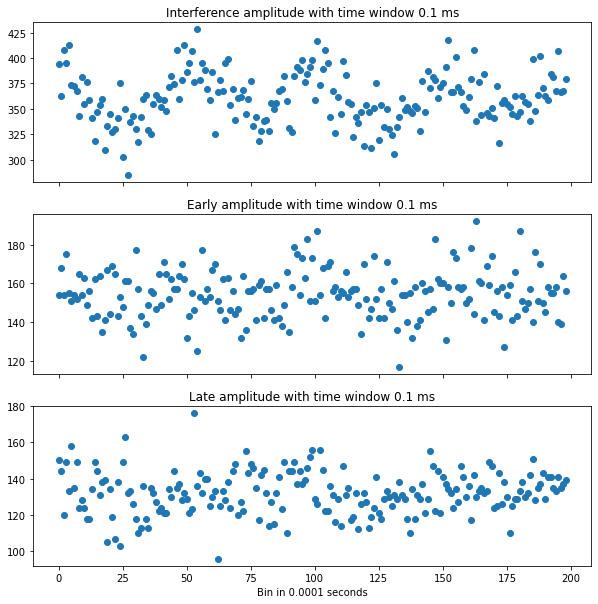

In [331]:
# Define the parameters for the analysis

integration_time = 100000000 # Integration time in ps, detection events for this time will be added
time_window = 20000000000 # Time window in ps, time for oscillation
time_frame = 2000000000000 # Time frame in ps, total time taken for overlay
total_time = t_integration*10**12 # Total time in ps
num_frame = 0 # What time window of the whole intergration time do you want to consider?
precision = 0.08 # Precision of the peak finding algorithm

interference_amplitude_list, time_array = display_oscillations(integration_time, time_window, time_frame, num_frame, timetag, precision, save_img=True, plot=True)



Fitted Amplitude: -7.841903155045826
Fitted Frequency [Hz]: 96.34657705147488
Fitted Phase: 0.1807656105448721
Data visibility for time window 0.1 ms =  0.20234604105571846
Fitted visibility for time window 0.1 ms =  0.022661958080022027


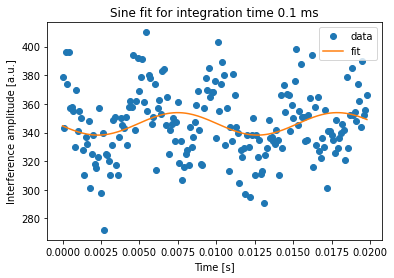

In [327]:
fitted_interfernce_amp, x_data, y_data, first_max, max_amp = fit_sine_and_visibility(interference_amplitude_list, time_array, integration_time, time_frame, timetag, save_img=True, plot=True)

In [84]:
first_peak_list = []

integration_time = 500000000 # Integration time in ps, detection events for this time will be added
time_window = 20000000000 # Time window in ps, time for oscillation
time_frame = 1000000000000 # Time frame in ps, total time taken for overlay
total_time = t_integration*10**12 # Total time in ps

for window in range(int(total_time/time_frame)-1):

    interference_amplitude_list, time_array = display_oscillations(integration_time, time_window, time_frame, window, timetag, save_img=True, plot=False)
    fitted_interfernce_amp, x_data, y_data, max_index, max_amp = fit_sine_and_visibility(interference_amplitude_list, time_array, integration_time, time_frame, timetag, save_img=True, plot=False)

    first_peak_list.append(max_amp)



<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Data visibility for time window 0.5 ms =  0.6073977936404932
Fitted visibility for time window 0.5 ms =  0.6056223035485937
Data visibility for time window 0.5 ms =  0.6058823529411764
Fitted visibility for time window 0.5 ms =  0.6037494566718651
Data visibility for time window 0.5 ms =  0.7026406429391504
Fitted visibility for time window 0.5 ms =  0.7163137573599782
Data visibility for time window 0.5 ms =  0.6512010529779533
Fitted visibility for time window 0.5 ms =  0.6804421288608674


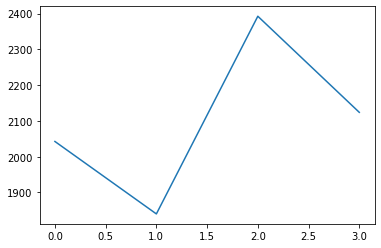

In [85]:
plt.plot(np.arange(0, int(total_time/time_frame)-1), first_peak_list)